## DAO Power Analysis



In [3]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport

from etherscan import Etherscan

import json
import time
import os
import random
import math

import scipy.stats as st


print(pd.__version__)
print(np.__version__)
print(requests.__version__)
print(plt.matplotlib.__version__)


1.3.4
1.21.2
2.26.0
3.5.0


Import authentication key.

In [4]:
# https://martin-thoma.com/configuration-files-in-python/

import json

with open("../3_api/.private/keys.json") as keys_file:
    KEYS = json.load(keys_file)

# Note: don't print the key, or if you do, delete the cell's output
# (cell outputs are saved and can be sent to Github).

#### Define functions to call different APIs

In [5]:
## DEEPDAO

def deepdao(query, params=None, post=False):

    ENDPOINT = 'https://api.deepdao.io/v0.1/'

    headers={
        'x-api-key': KEYS['DEEPDAO'],
        'accept': 'application/json'
    }

    if post:
        response = requests.post(ENDPOINT + query,
                                headers=headers,
                                json=params)
    else:
        response = requests.get(ENDPOINT + query,
                                headers=headers,
                                params=params)

    print(response)
    return response.json()

## ETHERSCAN
############

def etherscan(params={}):

    ENDPOINT = 'https://api.etherscan.io/api'

    params['apikey'] = KEYS['ETHERSCAN']

    response = requests.get(ENDPOINT,
                            headers={
                                'accept': 'application/json',
                                "User-Agent": ""
                            },
                            params=params)

    print(response)
    return response.json()


eth = Etherscan(KEYS['ETHERSCAN'])

## SNAPSHOT
###########

SNAPSHOT_ENDPOINT = "https://hub.snapshot.org/graphql"

snapshot = Client(
    transport=AIOHTTPTransport(url=SNAPSHOT_ENDPOINT)
)


def snapshot_rest(query, params=None):

    response = requests.post(SNAPSHOT_ENDPOINT,
                            headers={                      
                                'accept': 'application/json'
                            },
                            params={
                                'query': query
                            })

    print(response)
    return response.json()['data']

## THE GRAPH
############

## Endpoints depends on subgraph of interest.

## Load DAOs.

Saved in previous lecture.

In [6]:
## All Daos according to Deepdao
daos_deepdao = pd.read_json("../3_api/deepdao/data/daos_deepdao.json")
daos_deepdao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2275 entries, 0 to 2274
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   organizationId   2275 non-null   object
 1   name             2275 non-null   object
 2   description      2275 non-null   object
 3   logo             1466 non-null   object
 4   members          2275 non-null   int64 
 5   activeMembers    2275 non-null   int64 
 6   proposals        2275 non-null   int64 
 7   votes            2275 non-null   int64 
 8   governance       2268 non-null   object
 9   categories       358 non-null    object
 10  socialResources  2246 non-null   object
 11  updatedAt        2275 non-null   object
 12  tokens           239 non-null    object
dtypes: int64(4), object(9)
memory usage: 231.2+ KB


In [7]:
# ## Warning: it throws an error.

# ## All Daos according to Snapshot
# daos_snapshot = pd.read_json("../3_api/snapshot/data/daos_snapshot.json")
# daos_snapshot.info()

Workaround.

In [8]:
with open("../3_api/snapshot/data/daos_snapshot.json") as file:
    daos_snapshot = json.load(file)

daos_snapshot = pd.DataFrame(daos_snapshot)
daos_snapshot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10956 entries, 0 to 10955
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          10956 non-null  object
 1   name        10956 non-null  object
 2   about       10956 non-null  object
 3   network     10956 non-null  object
 4   symbol      10956 non-null  object
 5   strategies  10956 non-null  object
 6   admins      10956 non-null  object
 7   members     10956 non-null  object
 8   filters     10956 non-null  object
 9   plugins     10956 non-null  object
dtypes: object(10)
memory usage: 856.1+ KB


### Updated Utility Functions.


#### Load JSON files into Pandas.

Pandas throws an error if JSON contains too large ints, so we load JSON separately and then feed the Pandas.

In [9]:
def pd_read_json(file):
    ## Prevents Value too big Error.
    with open(file) as f:
        df = json.load(f)
    df = pd.DataFrame(df)
    return df

### Keep GQL queries separated.

GQL queries can be quite cumbersome, so it's better to write them into a separate file and then load them in here.

In [10]:
def get_query(filename, do_gql=False):
    with open("gql_queries/" + filename.replace(".gql", "") + ".gql") as f:
        query = f.read()
        if do_gql: query = gql(query)
    return query
    
## Alias gq.
gq = get_query

#### Enhanced API Wrapper

With this wrapper we want to:
- Save data as we download it in order to avoid data loss in case of an error (remote or local).
- Save the data periodically and in small chuncks, which is usually easier to load back.
- Catch errors as much as possible, to terminate gracefully the execution.
- Execute both GQL and simple rest requests for any type of query.


In [11]:
async def gql_all(query, field, first=1000, skip=None, initial_list=None, 
                  counter = True, limit=None, save=None, save_interval=10, clear_on_save = False, append=True, rest=False, data_dir="data", save_counter = 1, vars=None):

    ## The returned value and the varible used to accumulate results.
    out = []

    ## Utility function to save intermediate and final results.
    def save_json():

        # Pandas has problem load pure json saves.
        # Hence we create a pandas Dataframe and save it.
        # nonlocal append
        # flag = "a" if append else "w"
        # with open("data/" + save, flag) as f:
        #     json.dump(out, f)
        #     print("Saved.")

        nonlocal out
        df = pd.DataFrame(out)

        if clear_on_save:
            
            nonlocal save_counter
            
            sv = str(save_counter)
            sv = sv.zfill(5)
            save_counter += 1

            filename = save.replace('.json', '_' + sv + '.json')
            
            out = []
            out_str = "Saved and cleared."
        else:
            filename = save
            out_str = "Saved."
        
        df.to_json(data_dir + "/" + filename, orient="records")
        print(out_str)

        
    ## Load initial list.
    ## If no skip is provided, then skip is set to the length of
    ## the initial list, otherwise we use the user-specified value
    if initial_list:
        out = initial_list
        if skip is None:
            skip = len(out)
    elif skip is None:
        skip = 0

    ## Make a GQL query object, if necessary.
    if not rest and type(query) == str:
        query = gql(query)
        

    my_counter = 0
    fetch = True
    try:
        while fetch:
            
            my_counter += 1
            if limit and my_counter > limit:
                print('**Limit reached: ', limit)
                fetch = False
                continue

            if rest:

                # Building query manually.
                q = query.replace("($first: Int!, $skip: Int!)", "")
                q = q.replace("$first", str(first))
                q = q.replace("$skip", str(skip))
                # print(q)

                ## Optional additional variables.
                if vars:
                    for v in vars:
                        q = q.replace("$" + v, str(vars[v]))

                res = snapshot_rest(q)
                
            else:
                
                _vars = {"first": first, "skip": skip}
                
                ## Optional additional variables.
                if vars:
                    _vars ={**_vars, ** vars}

                res = await snapshot.execute_async(query, variable_values=_vars)
            
            if not res[field]:
                print('**I am done fetching!**')
                fetch = False
            else:
                out.extend(res[field])
                skip += first
                if counter: print(my_counter, len(out))

                if save and my_counter % save_interval == 0:
                    save_json()

        if save and my_counter % save_interval != 0:
            save_json()

    except Exception as e:
        print(str(e))
        print("**An error occurred, exiting early.**")
        if save: save_json()
    
    return out

As we split data from the API in multiple smaller files, we want to have a quick method to load them back into one place.

In [12]:
def pd_read_dir(dir, blacklist=None, whitelist=None, ext=('.json')):
    dir_df = pd.DataFrame()
    

    for file in os.listdir(dir):
        if blacklist and file in blacklist:
            continue
        if whitelist and file not in whitelist:
            continue

        if file.endswith(ext):
            tmp_df = pd_read_json(dir + '/' + file)
            dir_df = pd.concat([dir_df, tmp_df])
    
    return dir_df

## Spaces

We did not fetch all the useful information in the previous lecture. Let's do it again.

**Exercise: use the functions above to load all spaces**

Important! Try with GQL and with REST.

Remember to save the file.

Try different values of `first`.

In [13]:
## Your code here.
from re import S


q = get_query(filename="snapshot_spaces")
res = await gql_all(
    query = q, 
    field = "spaces",
    save = "snapshot_spaces.json"
)
res

# q = get_query(filename="snapshot_followers_of_space")
# res = await gql_all(
#     query=q, 
#     field="follows",
#     vars = {
#         "space": "yam.eth"
#     }    
# )


1 1000
2 2000
3 3000
4 4000
5 5000
6 6000
7 7000
8 8000
9 9000
10 10000
Saved.
11 11000
12 11195
**I am done fetching!**
Saved.


[{'id': 'bonustrack.eth',
  'name': 'Hi',
  'private': True,
  'about': '',
  'avatar': '',
  'terms': None,
  'location': None,
  'website': None,
  'twitter': None,
  'github': None,
  'email': None,
  'network': '1',
  'symbol': 'TICKET',
  'skin': 'aragon',
  'domain': 'vote.balancer.finance',
  'strategies': [{'name': 'ticket',
    'params': {'symbol': 'TICKET'},
    'network': '1'}],
  'admins': [],
  'members': ['0x24A12Fa313F57aF541d447c594072A992c605DCf',
   '0x8BBE4Ac64246d600BC2889ef5d83809D138F03DF',
   '0xeF8305E140ac520225DAf050e2f71d5fBcC543e7',
   '0x107174D70b33523E83711EA4C3F4229cdB8A7Cb1',
   '0x0b21Dbc34A953a35dFA629ad31e1cEE3dE0433Fb',
   '0x40FDAa1bff3BB87bC70955Be6657edBFdBeb122e',
   '0xcc6A949DB9b26a7173648d50Cf7C55e800E6585B',
   '0xC1C8ac723Fd9Db3db6E947dF42aaEdd28058A31D'],
  'filters': {'minScore': 0, 'onlyMembers': False},
  'plugins': {'safeSnap': {'address': '0xeF8305E140ac520225DAf050e2f71d5fBcC543e7'}},
  'voting': {'delay': None,
   'period': None,
  

**Exercise: verify that you can import the file containing the spaces that just saved**

In [14]:
spaces = pd_read_json("data/snapshot_spaces.json")

**Exercise: plot the relationship between followers and proposals across DAOs**

Question: ...and votes?
Bonus: jitter the dots, and try log scales.

In [18]:
spaces = pd.DataFrame(res)
spaces.info()
## Your code here.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11195 entries, 0 to 11194
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              11195 non-null  object
 1   name            11195 non-null  object
 2   private         11195 non-null  bool  
 3   about           11195 non-null  object
 4   avatar          11195 non-null  object
 5   terms           858 non-null    object
 6   location        7 non-null      object
 7   website         2337 non-null   object
 8   twitter         4831 non-null   object
 9   github          1876 non-null   object
 10  email           1 non-null      object
 11  network         11195 non-null  object
 12  symbol          11195 non-null  object
 13  skin            2987 non-null   object
 14  domain          2375 non-null   object
 15  strategies      11195 non-null  object
 16  admins          11195 non-null  object
 17  members         11195 non-null  object
 18  filter

### Checking last week home assignment.

- Pick a small (<1k), medium (<10k), and large  DAO (10k+)
- Get all members (if possible try different APIs)
- Order them by wealth in ETH
- Compute correlation ETH wealth and number of votes in the DAO


Let's see whether our cutpoints make sense.

In [19]:
def dao_size(x, T1=1000, T2=10000):
    if x < T1: return "small"
    if x < T2: return "medium"
    return "large"

spaces['size'] = spaces['followersCount'].apply(dao_size)

In [20]:
spaces['size'].value_counts()

small     11046
medium      125
large        24
Name: size, dtype: int64

Most of the DAOs are rather small in size.

In [21]:
spaces['followersCount'].describe()

count     11195.000000
mean        128.714873
std        1919.442484
min           0.000000
25%           1.000000
50%           3.000000
75%          11.000000
max      102707.000000
Name: followersCount, dtype: float64

In [22]:
spaces10 = spaces[spaces['followersCount'] >= 10]
spaces10.describe()

,followersCount,proposalsCount
count,3030.000000,3030.000000
mean,469.416172,15.963696
std,3668.291515,65.501408
min,10.000000,0.000000
25%,16.000000,2.000000
50%,31.500000,4.000000
75%,92.750000,11.000000
max,102707.000000,2264.000000


In [23]:
sm = spaces10[spaces10['size'] == "small"].sample(1)
sm[['name', 'followersCount', 'website']]


,name,followersCount,website
5432,Nuke Vaults,20,None


In [24]:
## id = hashflowdao.eth
DAO_ID = "hashflowdao.eth"
# DAO_ID = sm['id'].iloc[0]

In [25]:
query_followers = gq("snapshot_followers_of_space")
followers = await gql_all(query_followers, 
        field="follows", 
        vars={'space': DAO_ID }
    )

1 974
**I am done fetching!**


In [22]:
len(followers)

949

In [26]:
followers = pd.DataFrame(followers)
followers.head()


,follower
0,0x6430F34e563C719a74cDf9bdD565bc569B1CDf51
1,0xE199ea2CdCcDD08d793c2d25AE5b974cb38fCA72
2,0xa944e92483DDC42e70358760d4A5276be8e82767
3,0x969FB247acDD7c8e1dA46620e7C70521D37d4f94
4,0x3238e4dbb25EFEFc5d00624F949bc40e719a6F27


In [27]:
print(sum(followers.duplicated()))

0


Now we want to get the **wealth** in ETH of the followers.

Etherscan's api is quite handy...

**Exercise: finish the function below**

In [28]:
from etherscan import Etherscan
import json

with open("../3_api/.private/keys.json") as keys_file:
    KEYS = json.load(keys_file)

APIKEY = KEYS['ETHERSCAN']
eth = Etherscan(APIKEY)

In [29]:

def get_eth_wealth(addresses, K=20, limit=None):
    
    idx = 0
    counter = 0
    eth_wealth = []
    n_addresses = len(addresses)
    
    while (idx < n_addresses) and (limit is None or counter < limit):
        
        ## Your code here.
        my_addresses = addresses[idx: idx+K]
        res = eth.get_eth_balance_multiple(my_addresses)
        eth_wealth += res
        idx += K
        counter += 1
        print(counter, idx, len(eth_wealth))
    
    print('**Got all of them!')
    return eth_wealth

In [30]:
eth_wealth = get_eth_wealth(followers['follower'])

1 20 20
2 40 40
3 60 60
4 80 80
5 100 100
6 120 120
7 140 140
8 160 160
9 180 180
10 200 200
11 220 220
12 240 240
13 260 260
14 280 280
15 300 300
16 320 320
17 340 340
18 360 360
19 380 380
20 400 400
21 420 420
22 440 440
23 460 460
24 480 480
25 500 500
26 520 520
27 540 540
28 560 560
29 580 580
30 600 600
31 620 620
32 640 640
33 660 660
34 680 680
35 700 700
36 720 720
37 740 740
38 760 760
39 780 780
40 800 800
41 820 820
42 840 840
43 860 860
44 880 880
45 900 900
46 920 920
47 940 940
48 960 960
49 980 974
**Got all of them!


In [31]:
len(eth_wealth)

974

In [32]:
sm_wealth = pd.DataFrame(eth_wealth)

In [33]:
sm_wealth.head()

,account,balance
0,0x6430F34e563C719a74cDf9bdD565bc569B1CDf51,158086424803534476
1,0xE199ea2CdCcDD08d793c2d25AE5b974cb38fCA72,143360324733880574
2,0xa944e92483DDC42e70358760d4A5276be8e82767,1606900959375449
3,0x969FB247acDD7c8e1dA46620e7C70521D37d4f94,678944184894282
4,0x3238e4dbb25EFEFc5d00624F949bc40e719a6F27,101023656105411008


Get the votes of the space.

In [34]:
query_votes = gq("snapshot_votes_of_space")
votes = await gql_all(query_votes, 
        field="votes",         
        vars={'space': DAO_ID }
    )

1 1000
2 2000
3 2900
**I am done fetching!**


In [36]:
votes = pd.DataFrame(votes)
votes.info()
votes.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2900 non-null   object
 1   ipfs            2900 non-null   object
 2   voter           2900 non-null   object
 3   created         2900 non-null   int64 
 4   space           2900 non-null   object
 5   proposal        2900 non-null   object
 6   choice          2900 non-null   int64 
 7   metadata        2900 non-null   object
 8   reason          2900 non-null   object
 9   app             2900 non-null   object
 10  vp              2900 non-null   int64 
 11  vp_by_strategy  2900 non-null   object
 12  vp_state        2900 non-null   object
dtypes: int64(3), object(10)
memory usage: 294.7+ KB


,id,ipfs,voter,created,space,proposal,choice,metadata,reason,app,vp,vp_by_strategy,vp_state
0,0xe59241a0c7caa7df80b59699db152e062ae0f979e6b1...,Qmafz3CUF3DurMLwZWVcdzpvaXwSr3VdCnaPiQtnCUdDLX,0x1BaA7E3DDA9480f2fff7a62cFB92B56c0B35456E,1651420795,{'id': 'hashflowdao.eth'},{'id': '0x886f9da80077ffeac2269b9d9a4bdc60f5ff...,1,{},,,1,[1],final
1,0xf7eb9e85f2be15b9c064489573fe97a0c11de2ab1292...,QmWASPkMqKVSAjCLozkdt5Aa6FK77jGPdLZhh1fU9JqKRQ,0x298d0f26472e364Ea84090C80B09b187098F84b8,1651420749,{'id': 'hashflowdao.eth'},{'id': '0x886f9da80077ffeac2269b9d9a4bdc60f5ff...,1,{},,,1,[1],final
2,0x663cf2e839c1d483718887639d3fc6172f1bad207146...,QmUjkVGDiwf8rEwko2YWownhJpDN1xYnLVnqLUnDqhLKke,0x8Fffb08a892B348C3df82695F55F866D85BCD358,1651420689,{'id': 'hashflowdao.eth'},{'id': '0x886f9da80077ffeac2269b9d9a4bdc60f5ff...,1,{},,,1,[1],final
3,0x97d7c5eab61e6f98063caefe67cb559b4d964ca4f73a...,QmWLasNke1mKYvkmQgj7uk2vNCsthSKi6TuCwV5MUEtEK7,0x31A95aDAa9435f6381Ab41b38C6C8150Bcb845E9,1651420640,{'id': 'hashflowdao.eth'},{'id': '0x886f9da80077ffeac2269b9d9a4bdc60f5ff...,1,{},,,1,[1],final
4,0xf2c3ff59b8f86d850f204b2368b560dc5615dc63edee...,QmPkstby2HozH1DUxx6vM1ShYPQzEoKUFA7rBq5kwFoB6u,0xf517C1A78d0769B7BEdF26217e4FcAe4C727D0a0,1651420188,{'id': 'hashflowdao.eth'},{'id': '0x886f9da80077ffeac2269b9d9a4bdc60f5ff...,1,{},,,1,[1],final


**Exercise: Unnest proposal id.**

In [37]:
## Your code here.
votes["space"] = votes.space.map(lambda x: x['id'])
votes["proposal"] = votes.proposal.map(lambda x: x['id'])

In [38]:
votes.head()

,id,ipfs,voter,created,space,proposal,choice,metadata,reason,app,vp,vp_by_strategy,vp_state
0,0xe59241a0c7caa7df80b59699db152e062ae0f979e6b1...,Qmafz3CUF3DurMLwZWVcdzpvaXwSr3VdCnaPiQtnCUdDLX,0x1BaA7E3DDA9480f2fff7a62cFB92B56c0B35456E,1651420795,hashflowdao.eth,0x886f9da80077ffeac2269b9d9a4bdc60f5ff158e0f93...,1,{},,,1,[1],final
1,0xf7eb9e85f2be15b9c064489573fe97a0c11de2ab1292...,QmWASPkMqKVSAjCLozkdt5Aa6FK77jGPdLZhh1fU9JqKRQ,0x298d0f26472e364Ea84090C80B09b187098F84b8,1651420749,hashflowdao.eth,0x886f9da80077ffeac2269b9d9a4bdc60f5ff158e0f93...,1,{},,,1,[1],final
2,0x663cf2e839c1d483718887639d3fc6172f1bad207146...,QmUjkVGDiwf8rEwko2YWownhJpDN1xYnLVnqLUnDqhLKke,0x8Fffb08a892B348C3df82695F55F866D85BCD358,1651420689,hashflowdao.eth,0x886f9da80077ffeac2269b9d9a4bdc60f5ff158e0f93...,1,{},,,1,[1],final
3,0x97d7c5eab61e6f98063caefe67cb559b4d964ca4f73a...,QmWLasNke1mKYvkmQgj7uk2vNCsthSKi6TuCwV5MUEtEK7,0x31A95aDAa9435f6381Ab41b38C6C8150Bcb845E9,1651420640,hashflowdao.eth,0x886f9da80077ffeac2269b9d9a4bdc60f5ff158e0f93...,1,{},,,1,[1],final
4,0xf2c3ff59b8f86d850f204b2368b560dc5615dc63edee...,QmPkstby2HozH1DUxx6vM1ShYPQzEoKUFA7rBq5kwFoB6u,0xf517C1A78d0769B7BEdF26217e4FcAe4C727D0a0,1651420188,hashflowdao.eth,0x886f9da80077ffeac2269b9d9a4bdc60f5ff158e0f93...,1,{},,,1,[1],final


In [39]:
votes['proposal'].value_counts()

0x886f9da80077ffeac2269b9d9a4bdc60f5ff158e0f9312f96be0af081b1a5963    2900
Name: proposal, dtype: int64

In [40]:
votes['voter'].value_counts()

0x1BaA7E3DDA9480f2fff7a62cFB92B56c0B35456E    1
0xD42f7148D63e567126f3F436B745C3ADa2F2aFA6    1
0xCA241c81f27161C753fD11DDEd3B8738E3D1B62E    1
0xb6F00a713153Cbaf39FB0BfdE52AdD5795a43C80    1
0xF76bf0f87E42Ce159fbD9b730fA9c676dE43c716    1
                                             ..
0x27670a5383D252fD7028ce7FE55A6a68127E8Ce1    1
0x5426e265e7681C29746009841dE3d369C840C556    1
0x5B15AAB04EC5E3058AB2921A8F2f94FD26ed581C    1
0x32388db1e4AF84ac25742c76C4731025DA0E8f3B    1
0xFf918a3Ff6CCc3722197B555a7a30de9A37906dB    1
Name: voter, Length: 2900, dtype: int64

In [41]:
votes['choice'].value_counts()

1    1630
2    1143
3     127
Name: choice, dtype: int64

We have more votes than followers...\
After inquirying with Snapshot staff on Discord, **it is possible to vote without following an organization.**\
Let's get the wealth of all voters.

In [52]:
eth_wealth2 = get_eth_wealth(votes['voter'])

1 20 20
2 40 40
3 60 60
4 80 80
5 100 100
6 120 120
7 140 140
8 160 160
9 180 180
10 200 200
11 220 220
12 240 240
13 260 260
14 280 280
15 300 300
16 320 320
17 340 340
18 360 360
19 380 380
20 400 400
21 420 420
22 440 440
23 460 460
24 480 480
25 500 500
26 520 520
27 540 540
28 560 560
29 580 580
30 600 600
31 620 620
32 640 640
33 660 660
34 680 680
35 700 700
36 720 720
37 740 740
38 760 760
39 780 780
40 800 800
41 820 820
42 840 840
43 860 860
44 880 880
45 900 900
46 920 920
47 940 940
48 960 960
49 980 980
50 1000 1000
51 1020 1020
52 1040 1040
53 1060 1060
54 1080 1080
55 1100 1100
56 1120 1120
57 1140 1140
58 1160 1160
59 1180 1180
60 1200 1200
61 1220 1220
62 1240 1240
63 1260 1260
64 1280 1280
65 1300 1300
66 1320 1320
67 1340 1340
68 1360 1360
69 1380 1380
70 1400 1400
71 1420 1420
72 1440 1440
73 1460 1460
74 1480 1480
75 1500 1500
76 1520 1520
77 1540 1540
78 1560 1560
79 1580 1580
80 1600 1600
81 1620 1620
82 1640 1640
83 1660 1660
84 1680 1680
85 1700 1700
86 1720 17

In [55]:
eth_wealth2

[{'account': '0x1BaA7E3DDA9480f2fff7a62cFB92B56c0B35456E',
  'balance': '9227623336239750'},
 {'account': '0x298d0f26472e364Ea84090C80B09b187098F84b8',
  'balance': '1313058536808346'},
 {'account': '0x8Fffb08a892B348C3df82695F55F866D85BCD358',
  'balance': '4938400684681228'},
 {'account': '0x31A95aDAa9435f6381Ab41b38C6C8150Bcb845E9',
  'balance': '10346809650713943'},
 {'account': '0xf517C1A78d0769B7BEdF26217e4FcAe4C727D0a0',
  'balance': '8098745663244817'},
 {'account': '0xCb6012f6E83e73AEb0f8fE650FAF1f64BcdA2709',
  'balance': '6658581243856640'},
 {'account': '0x4f6420E54191389555d33C0850E8eC66dcCBcD45',
  'balance': '42246827870140413'},
 {'account': '0xd2F7Bb62504FBe33e3038bf2fefAEaB42bad88B3',
  'balance': '38044711527633304'},
 {'account': '0xf938097bd64b0f9C969983B361a07EdFE9143552',
  'balance': '111300005548672131'},
 {'account': '0x68a78F3b7Ed88a22e5e158320e0d15B52eDFa312',
  'balance': '28200984544995111'},
 {'account': '0x8adFc6e6E6DA6Ed9aF7F094B3f3115ED72048395',
  'ba

In [56]:
sm_wealth = pd.DataFrame(eth_wealth2)
sm_wealth.head()

,account,balance
0,0x1BaA7E3DDA9480f2fff7a62cFB92B56c0B35456E,9227623336239750
1,0x298d0f26472e364Ea84090C80B09b187098F84b8,1313058536808346
2,0x8Fffb08a892B348C3df82695F55F866D85BCD358,4938400684681228
3,0x31A95aDAa9435f6381Ab41b38C6C8150Bcb845E9,10346809650713943
4,0xf517C1A78d0769B7BEdF26217e4FcAe4C727D0a0,8098745663244817


In [57]:
votes_wealth = pd.merge(sm_wealth, votes, left_on="account", right_on="voter")
votes_wealth['balance'] = votes_wealth['balance'].astype('float64')
votes_wealth.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2900 entries, 0 to 2899
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   account         2900 non-null   object 
 1   balance         2900 non-null   float64
 2   id              2900 non-null   object 
 3   ipfs            2900 non-null   object 
 4   voter           2900 non-null   object 
 5   created         2900 non-null   int64  
 6   space           2900 non-null   object 
 7   proposal        2900 non-null   object 
 8   choice          2900 non-null   int64  
 9   metadata        2900 non-null   object 
 10  reason          2900 non-null   object 
 11  app             2900 non-null   object 
 12  vp              2900 non-null   int64  
 13  vp_by_strategy  2900 non-null   object 
 14  vp_state        2900 non-null   object 
dtypes: float64(1), int64(3), object(11)
memory usage: 362.5+ KB


In [58]:
df_groups = votes_wealth.groupby('choice')


In [59]:
df_groups['balance'].describe() 


,count,mean,std,min,25%,50%,75%,max
choice,,,,,,,,
1,1630.0,1.644328e+17,1.477505e+18,0.000000e+00,7.338288e+15,1.952524e+16,7.824579e+16,5.288468e+19
2,1143.0,1.497961e+17,8.252119e+17,0.000000e+00,9.523568e+15,2.558848e+16,1.033446e+17,2.472459e+19
3,127.0,8.438756e+16,2.163363e+17,1.807249e+13,5.121654e+15,1.246275e+16,5.639688e+16,1.800077e+18


In [64]:
stats = df_groups['balance'].agg(['mean', 'sem'])
stats['ci95_hi'] = (stats['mean'] + 1.96* stats['sem'])
stats['ci95_lo'] = (stats['mean'] - 1.96* stats['sem'])
stats

,mean,sem,ci95_hi,ci95_lo
choice,,,,
1,1.644328e+17,3.659613e+16,2.361612e+17,9.270437e+16
2,1.497961e+17,2.440857e+16,1.976369e+17,1.019553e+17
3,8.438756e+16,1.919675e+16,1.220132e+17,4.676194e+16


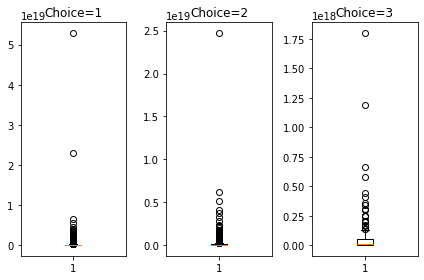

In [66]:
fig, axes = plt.subplots(ncols=3, nrows=1)

for c, ax in enumerate(axes.flatten()):
    c +=1
    x = votes_wealth[votes_wealth['choice'] == c]
    ax.boxplot(x['balance'])

    ax.set_title('Choice={}'.format(c))

plt.tight_layout()

#### Messages

We get a better idea about the history of our DAO.

In [67]:
query = gq("snapshot_messages_of_space")
messages = await gql_all(query,
        field="messages", 
        # rest=True,
        # save="snapshot_followers_small.json",
        data_dir="data/",
        first=1000,
        vars={'space': DAO_ID }
    )

1 1000
2 2000
3 3000
4 3539
**I am done fetching!**


In [68]:
messages = pd.DataFrame(messages)
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3539 entries, 0 to 3538
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   mci        3539 non-null   int64 
 1   id         3539 non-null   object
 2   ipfs       3539 non-null   object
 3   address    3539 non-null   object
 4   version    3539 non-null   object
 5   timestamp  3539 non-null   int64 
 6   space      3539 non-null   object
 7   type       3539 non-null   object
 8   sig        3539 non-null   object
 9   receipt    3539 non-null   object
dtypes: int64(2), object(8)
memory usage: 276.6+ KB


In [69]:
messages.head()

,mci,id,ipfs,address,version,timestamp,space,type,sig,receipt
0,9127606,0xd7d321b42db92ad30d14d3326dedc334d0396b1acdad...,bafkreibzmzihosvs2j2gxltfoij46zzulmlacjbmczc4f...,0xcC0ce82d2C580f78243ab48E18bf572B2A47902E,0.1.4,1664889143,hashflowdao.eth,follow,0x4ff82298a7bd1814d5c064c428af7ee3cffea46a1fff...,0x0cd02f019afdf96e94daaffe7e2ce5f608063e793313...
1,9125567,0x24f2e6dce95605c26729322cb80ebacab28431845cd2...,bafkreidege7fpv4u6i24lnxkrvtnq2gs3ihtxx6r2zgci...,0x6726aC7A0d3EF9b7b9ff60fc8fcd5F9324d4238F,0.1.4,1664880851,hashflowdao.eth,follow,0x16bcb9059f3a4737dadb4631406dd411fe9880b6f662...,0xee396a079307fa0225b7d3359d766572ff2950f81517...
2,9123575,0x9decf88607c82f2f95857735d5bdbfb448840165ca0a...,bafkreievm6uvzrzo3qffph7fqpjvyvy4oxkdak5o2vcd7...,0x9424f29a7Fa532E21045bb7A67531F493852bb0E,0.1.4,1664867728,hashflowdao.eth,follow,0x8e29e087c2d03561b6fffb89f1882da8e8466883beab...,0xc1eeb6253b8b40f9831a7251314c745bc454176e8bee...
3,9123394,0x46a597a6d5328b441403339901289b976c007d6a405c...,bafkreiaptrmcncyvlhsdhnerhycglao5kwzw5gfwb3dhc...,0x58729D55B934119D6DE2392E88044DAc3ebEb222,0.1.4,1664866526,hashflowdao.eth,follow,0x4c35f93019196cea04e0ae581e0e9f4485b615df1c1f...,0xa43c334bd48dfde02462c1f56016b231ce4a70dc12f5...
4,9118271,0xcc3bd913229aaa1d8f67f04fc726f0fda80db0f847a7...,bafkreid6eyfvfdfd6txu3fbvdsolbylhp5dt362waajtk...,0xE73526CA91E7513D2f7ed6973B0604E74Db1FB5c,0.1.4,1664821502,hashflowdao.eth,unfollow,0xec77ce6e887fabfee2fd9b527e66a21ed8df09903d10...,0x3b6b92ab8bc0082ae1f20296138eea5b8761b0e1d13b...


In [70]:
messages['type'].value_counts()

vote                3164
follow               312
unfollow              45
subscribe             12
archive-proposal       5
proposal               1
Name: type, dtype: int64

The number of votes is larger than what we downloaded and the number of follows smaller. After inquiring with the Snapshot's staff on Discord:

- admins might have deleted/closed/archived some proposals,
- one should check the data of creation of a dato, as some features of the platform might have been added later. 